# load data

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/datasets/except_hurt.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/neutrality/1f75545eb58a1cfdcbcfa750a78c9f936b749dfb83b0dbc1e9a98e830ccac6c0_┐й_20_┴▀╕│_░°░°╜├╝│_┴╛▒│_└╟╖с╜├╝│_20210122185121-001-004.jpg  
  inflating: train/neutrality/1f75545eb58a1cfdcbcfa750a78c9f936b749dfb83b0dbc1e9a98e830ccac6c0_┐й_20_┴▀╕│_╡╡╜╔ ╚п░ц_20210122185346-008-011.jpg  
  inflating: train/neutrality/1f75545eb58a1cfdcbcfa750a78c9f936b749dfb83b0dbc1e9a98e830ccac6c0_┐й_20_┴▀╕│_╗є╛ў╜├╝│_┴б╞ў_╜├└х_20210122185217-003-015.jpg  
  inflating: train/neutrality/1f75545eb58a1cfdcbcfa750a78c9f936b749dfb83b0dbc1e9a98e830ccac6c0_┐й_20_┴▀╕│_╝ў╣┌ ╣╫ ░┼┴╓░°░г_20210122173113-010-003.jpg  
  inflating: train/neutrality/1f75545eb58a1cfdcbcfa750a78c9f936b749dfb83b0dbc1e9a98e830ccac6c0_┐й_20_┴▀╕│_╜║╞ў├ў ░№╢ў ╣╫ ╖╣└·╜├╝│_20210122185231-004-003.jpg  
  inflating: train/neutrality/1f830bb52573ddb5f8913e0c233cb34b2847050021b5fe8e4e91f3f2f121e3c5_│▓_20_┴▀╕│_▒│┼ы_└╠╡┐╝Ў┤▄(┐д╕о║г└╠┼═ ╞ў╟╘)_20210203121141-002-005.jpg  
  inflating: train/neutrality/

In [3]:
train_dir = 'train'
valid_dir = 'validation'

# build Model

In [ ]:
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
from tensorflow.keras.applications.xception import Xception
conv_base = Xception(include_top=False,
                     weights='imagenet',
                     input_shape=(206,278,3))

83697664/83683744 [==============================] - 1s 0us/step


In [5]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 206, 278, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 102, 138, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 102, 138, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

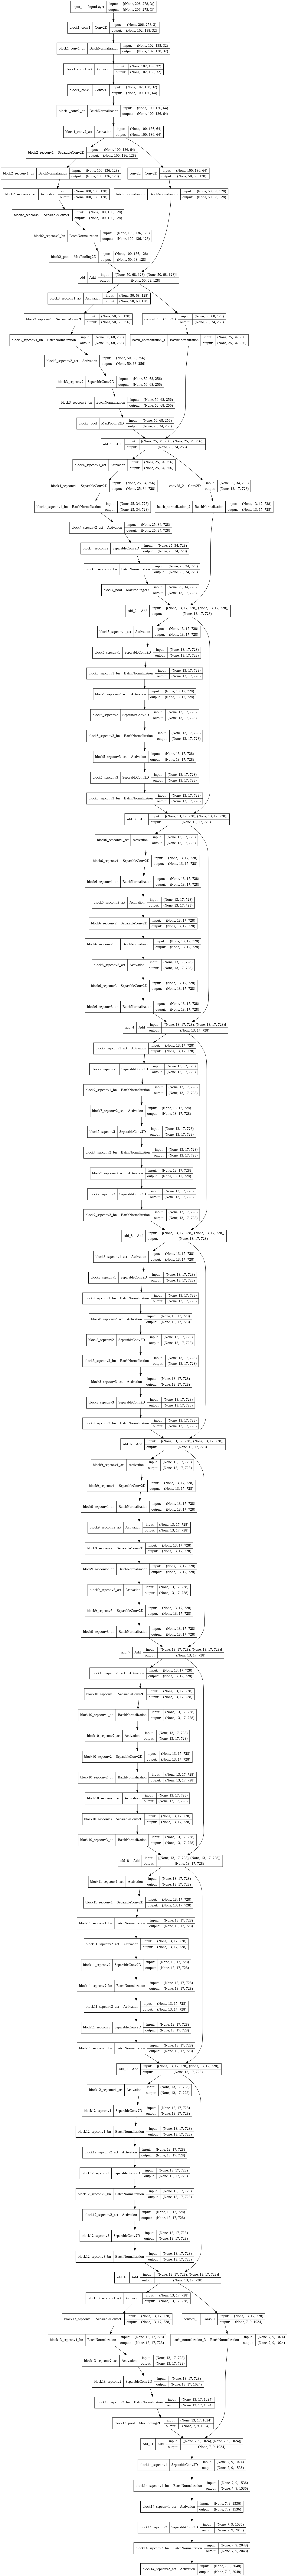

In [6]:
from tensorflow.keras.utils import plot_model

plot_model(conv_base, show_shapes=True, show_layer_names=True,rankdir='TB', to_file='model.png')

In [7]:
conv_base.trainable=True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block14_sepconv2':
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_dim=7 * 9 * 2048))
model.add(layers.Dense(6, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 9, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 129024)            0         
                                                                 
 dense (Dense)               (None, 256)               33030400  
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 53,893,422
Trainable params: 36,195,590
Non-trainable params: 17,697,832
_________________________________________________________________


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (206,278),
    batch_size=32,
    class_mode = 'categorical')

valid_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size = (206, 278),
    batch_size = 32,
    class_mode = 'categorical')

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=2e-5),
              metrics = ['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=188,
                    epochs=14,
                    validation_data=valid_generator,
                    validation_steps=75)

Found 6000 images belonging to 6 classes.
Found 2400 images belonging to 6 classes.
Epoch 1/14
188/188 [==============================] - 241s 1s/step - loss: 1.6378 - acc: 0.3433 - val_loss: 1.4967 - val_acc: 0.3983
Epoch 2/14
188/188 [==============================] - 209s 1s/step - loss: 1.4385 - acc: 0.4288 - val_loss: 1.5341 - val_acc: 0.4121
Epoch 3/14
188/188 [==============================] - 207s 1s/step - loss: 1.3617 - acc: 0.4642 - val_loss: 1.4172 - val_acc: 0.4462
Epoch 4/14
188/188 [==============================] - 206s 1s/step - loss: 1.3002 - acc: 0.4987 - val_loss: 1.4931 - val_acc: 0.4354
Epoch 5/14
188/188 [==============================] - 204s 1s/step - loss: 1.2556 - acc: 0.5175 - val_loss: 1.4725 - val_acc: 0.4417
Epoch 6/14
188/188 [==============================] - 208s 1s/step - loss: 1.1981 - acc: 0.5365 - val_loss: 1.4352 - val_acc: 0.4625
Epoch 7/14
188/188 [==============================] - 207s 1s/step - loss: 1.1609 - acc: 0.5580 - val_loss: 1.4460 - v

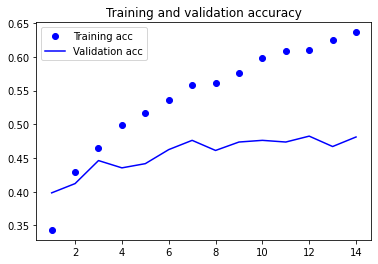

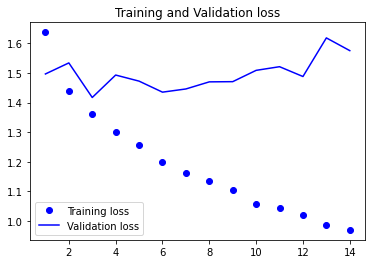

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [14]:
model.save('/content/drive/My Drive/Colab Notebooks/models/except_hurt_Xception_aug_14.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [1]:
import numpy as np

np.argmax([1,2,3])

2